### Imports

In [12]:
from gensim.models import Word2Vec, KeyedVectors
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Métricas
from sklearn.model_selection import train_test_split
import string


mpl.rcParams['figure.figsize'] = (10, 7)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data

In [13]:
debate_gov = pd.read_csv('government_debate_twitter.csv', sep=',', encoding='utf-8')
display(debate_gov.head())
display(debate_gov.shape)

,author_id,created_at,id,lang,retweet_count,text,sinal
0,"1,46E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,45,RT @EdegarPretto O meu candidato vice-governad...,1.0
1,"1,51E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,0,Periga o Argenta chamar o Simon pra responder ...,NaN
2,"1,06E+18",2022-08-08T01:08:21Z,"1,56E+18",pt,14,RT @WinstonLing Segue o link para assistirem o...,1.0
3,"7,15E+17",2022-08-08T01:08:20Z,"1,56E+18",pt,88,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,NaN
4,1455004730,2022-08-08T01:08:20Z,"1,56E+18",pt,0,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0


(3000, 7)

#### Selecting only texts and labels

In [14]:
debate_gov = debate_gov[['text', 'sinal']]
debate_gov.head()

,text,sinal
0,RT @EdegarPretto O meu candidato vice-governad...,1.0
1,Periga o Argenta chamar o Simon pra responder ...,NaN
2,RT @WinstonLing Segue o link para assistirem o...,1.0
3,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,NaN
4,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0


## Data cleaning

#### Removing null data

In [15]:
debate_gov.dropna(inplace=True)
debate_gov.shape

(1372, 2)

Verificando o balanceamento do nosso Dataset

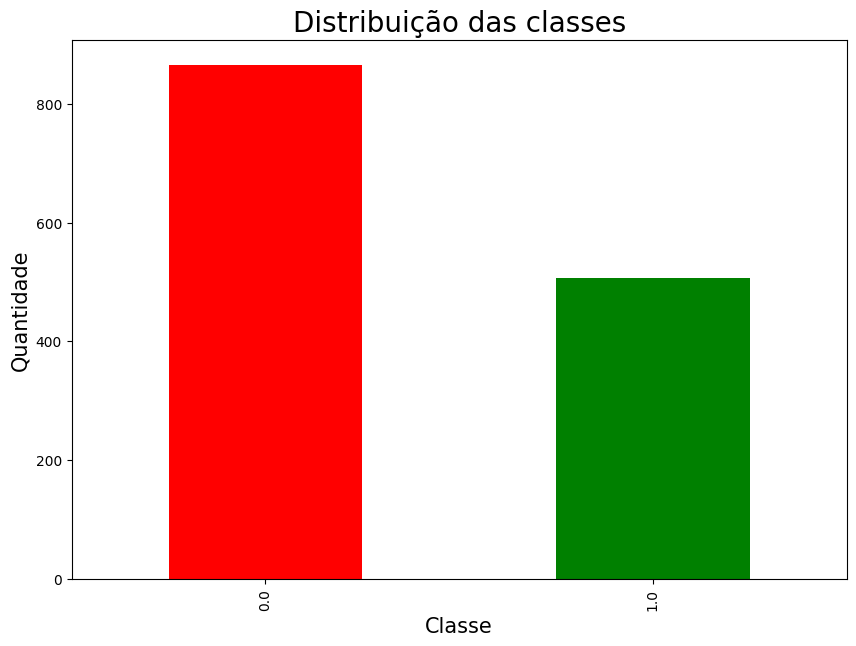

In [16]:
debate_gov['sinal'].value_counts().plot(kind='bar', color=['red', 'green']);
plt.title('Class distribution', fontsize=20);
plt.xlabel('Class', fontsize=15);
plt.ylabel('Amount', fontsize=15);
sns.set_style("whitegrid");

#### Apart from stop words, punctuations, numbers...

In [17]:
def pre_process_text(texto):
    palavras_extras = ['bandrs', 'band', 'link', 'rt', 'debate']
    nopont = [char for char in texto if char not in string.punctuation]
    nopont = ''.join(nopont)
    sms = [word for word in nopont.split() if not word.isnumeric()]
    sms = [word for word in sms if word.lower() not in palavras_extras]
    sms = [word for word in sms if word.lower() not in stopwords.words('portuguese')]
    sms = ' '.join(sms)
    return sms


textos_processados = debate_gov['text'].apply(pre_process_text)

#### New DataFrame processed

In [18]:
debate_gov_processado = pd.DataFrame(
    {'text': textos_processados,
    'sinal': debate_gov['sinal']}    
)

debate_gov_processado.head()

,text,sinal
0,EdegarPretto candidato vicegovernador PedroRua...,1.0
2,WinstonLing Segue assistirem hoje internet vam...,1.0
4,wmfigueiredo evertonvf EduardoLeite gostam gov...,0.0
5,EduardoLeite 🤡,0.0
6,governamos Rio Grande Sul oliviodutra tarsogen...,0.0


# Modeling

## Word vectors using Word2Vec

#### Configuring parameters

In [20]:
w2v = Word2Vec(sg=1, window=5, vector_size=200, min_count=3, alpha=0.03, min_alpha=0.0010)

#### Building vocabulary

In [21]:
tokens = [txt.split(" ") for txt in debate_gov_processado['text']] # Tokenização que é uma lista de lista de palavras

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
w2v.build_vocab(tokens, progress_per=1000)

2023-03-12 19:41:32,869 : INFO : collecting all words and their counts
2023-03-12 19:41:32,872 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-03-12 19:41:32,875 : INFO : PROGRESS: at sentence #1000, processed 12317 words, keeping 3683 word types
2023-03-12 19:41:32,877 : INFO : collected 4387 word types from a corpus of 16577 raw words and 1372 sentences
2023-03-12 19:41:32,878 : INFO : Creating a fresh vocabulary
2023-03-12 19:41:32,886 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 1194 unique words (27.22% of original 4387, drops 3193)', 'datetime': '2023-03-12T19:41:32.885424', 'gensim': '4.3.1', 'python': '3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]', 'platform': 'Linux-5.10.102.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
2023-03-12 19:41:32,887 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=3 leaves 12736 word corpus (76.83% of original 1657

### Training

In [22]:
w2v.train(tokens, total_examples=w2v.corpus_count, epochs=30)

2023-03-12 19:41:32,919 : INFO : Word2Vec lifecycle event {'msg': 'training model with 3 workers on 1194 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2023-03-12T19:41:32.919951', 'gensim': '4.3.1', 'python': '3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]', 'platform': 'Linux-5.10.102.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'train'}
2023-03-12 19:41:32,959 : INFO : EPOCH 0: training on 16577 raw words (10650 effective words) took 0.0s, 361085 effective words/s
2023-03-12 19:41:32,990 : INFO : EPOCH 1: training on 16577 raw words (10635 effective words) took 0.0s, 390454 effective words/s
2023-03-12 19:41:33,023 : INFO : EPOCH 2: training on 16577 raw words (10622 effective words) took 0.0s, 381103 effective words/s
2023-03-12 19:41:33,060 : INFO : EPOCH 3: training on 16577 raw words (10639 effective words) took 0.0s, 343365 effective words/s
2023-03-12 19:41:33,091 : I

(319684, 497310)

Saving the model

In [23]:
w2v.wv.save_word2vec_format('w2v model\word2vec.txt', binary=False)

2023-03-12 19:41:33,941 : INFO : storing 1194x200 projection weights into w2v model\word2vec.txt


Loading model

In [24]:
w2v_skip_gram = KeyedVectors.load_word2vec_format('w2v model\word2vec.txt', binary=False)

2023-03-12 19:41:34,074 : INFO : loading projection weights from w2v model\word2vec.txt
2023-03-12 19:41:34,191 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (1194, 200) matrix of type float32 from w2v model\\word2vec.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-03-12T19:41:34.191858', 'gensim': '4.3.1', 'python': '3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]', 'platform': 'Linux-5.10.102.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}


### Creating word vectors in training and testing

In [25]:
def tokenizador(texto):
    sms = pre_process_text(texto)
    return sms.split(' ')


In [26]:
def combina_vetores(palavras, modelo):
    vetor_resultante = np.zeros((1, 200))
    for palavra in palavras:
        try:
            vetor_resultante += modelo.get_vector(palavra)
        except:
            pass
    return vetor_resultante

In [27]:
def matriz_vetores(textos, modelo):
    x = len(textos)
    y = 200
    matriz = np.zeros((x, y))

    for i in range(x):
        palavras = tokenizador(textos.iloc[i])
        matriz[i] = combina_vetores(palavras, modelo)

    return matriz

#### Train and text split

In [28]:
X = debate_gov_processado['text']
y = debate_gov_processado['sinal']

textos_treino, textos_teste, labels_treino, labels_teste = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Matrices

In [29]:
matriz_treino = matriz_vetores(textos_treino, w2v_skip_gram)
matriz_teste = matriz_vetores(textos_teste, w2v_skip_gram)

print(matriz_treino.shape), print(labels_treino.shape)
print(matriz_teste.shape), print(labels_teste.shape)

(1097, 200)
(1097,)
(275, 200)
(275,)


(None, None)

# KNN

In [30]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(matriz_treino, labels_treino)
y_pred_knn = knn.predict(matriz_teste)

In [31]:
acuracia_knn = accuracy_score(labels_teste, y_pred_knn).round(2) * 100
precisao_knn = precision_score(labels_teste, y_pred_knn).round(2) * 100
recall_knn = recall_score(labels_teste, y_pred_knn).round(2) * 100
f1_knn = f1_score(labels_teste, y_pred_knn).round(2) * 100

print(f'Accuracy: {acuracia_knn}%, Precision: {precisao_knn}%, Recall: {recall_knn}%, F1: {f1_knn}%')

Acurácia: 78.0%, Precisão: 75.0%, Recall: 60.0%, F1: 67.0%


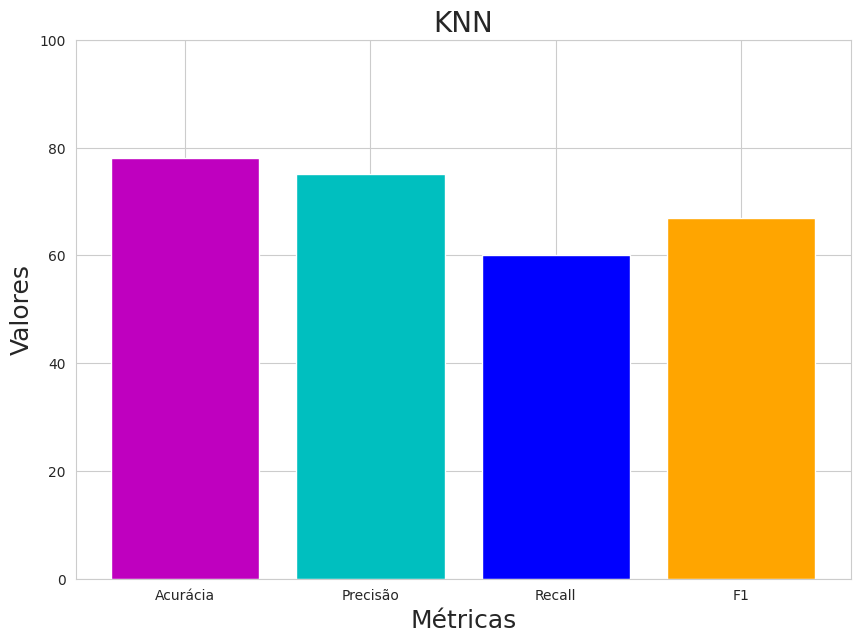

In [32]:
sns.set_style('whitegrid')

plt.bar(['Accuracy', 'Precision', 'Recall', 'F1'], [acuracia_knn, precisao_knn, recall_knn, f1_knn], color=['m', 'c', 'b', 'orange']);
plt.title('KNN', fontsize=20);

plt.xlabel('Metrics', fontsize=18);
plt.ylabel('Valores', fontsize=18);
plt.ylim(0, 100);

# Perceptron

In [33]:
perceptron = Perceptron(penalty='l2', max_iter=1000, random_state=42)
perceptron.fit(matriz_treino, labels_treino)
y_pred_perceptron = perceptron.predict(matriz_teste)

In [34]:
acuracia_perceptron = accuracy_score(labels_teste, y_pred_perceptron).round(2) * 100
precisao_perceptron = precision_score(labels_teste, y_pred_perceptron).round(2) * 100
recall_perceptron = recall_score(labels_teste, y_pred_perceptron).round(2) * 100
f1_perceptron = f1_score(labels_teste, y_pred_perceptron).round(2) * 100

print(f'Accuracy: {acuracia_perceptron}%, Precision: {precisao_perceptron}%, Recall: {recall_perceptron}%, F1: {f1_perceptron}%')

Acurácia: 71.0%, Precisão: 57.99999999999999%, Recall: 80.0%, F1: 67.0%


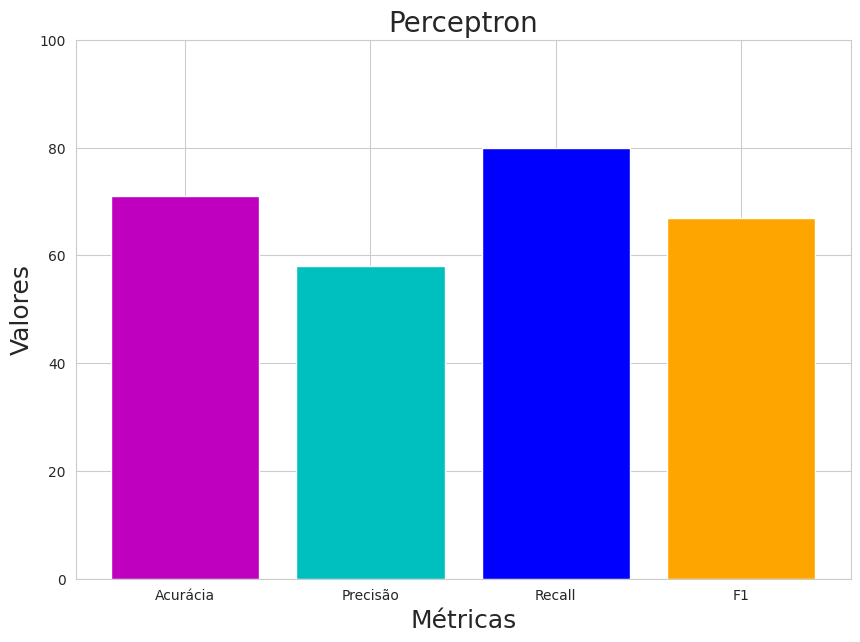

In [35]:
plt.bar(['Accuracy', 'Precision', 'Recall', 'F1'], [acuracia_perceptron, precisao_perceptron, recall_perceptron, f1_perceptron], color=['m', 'c', 'b', 'orange']);
plt.title('Perceptron', fontsize=20);

plt.xlabel('Metrics', fontsize=18);
plt.ylabel('Valores', fontsize=18);
plt.ylim(0, 100);